In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pysal.model import mgwr
from scipy.stats import pearsonr
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from urbana.models.plot_predictions import PredictedAccuracy
from urbana.constants import DIR_REPO, DIR_DATA

from pathlib import Path

DATA_PATH = Path("../data")

SCL_DATA_PATH = DATA_PATH / "raw" / "scl"
PATH_CENSUS = SCL_DATA_PATH / "census"

INTERIM_CL = DATA_PATH / "interim" / "scl"

EXTERNAL_CL = DATA_PATH / "external" / "scl"
PATH_URBAN_AREAS = EXTERNAL_CL / "urban_areas"
PATH_R13 = EXTERNAL_CL / "R13"

/home/flac/miniconda3/envs/urbana/lib/python3.12/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [4]:
# papermill parameters cell
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html

OUTPUT_WARNINGS = False
SAVE_FIGS = True
FIT_INTERCEPT = True

VARIABLE_TO_PREDICT = "Airbnb_Count"

In [5]:
if OUTPUT_WARNINGS is False:
    import warnings

    warnings.filterwarnings("ignore")

In [6]:
# Create folders to store the data
PROCESSED_CL = DATA_PATH / "processed" / "scl"
DIR_VAR = PROCESSED_CL / "{}".format(VARIABLE_TO_PREDICT)
DIR_GWR = DIR_VAR / "02_gwr"

if SAVE_FIGS:
    folder_list = [
        DIR_GWR,
        DIR_GWR / "coefficients",
    ]

    for folder in folder_list:
        if not os.path.exists(folder):
            os.makedirs(folder)

In [7]:
PATH_TO_FILE = INTERIM_CL / "census_processed.csv"
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebook "11_census_acquisition.ipynb" with the same date and "SAVE_DATA" set to True'
    )

In [8]:
PATH_TO_FILE = PROCESSED_CL / VARIABLE_TO_PREDICT / "01_linear/coefficients.csv"
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebook "12_census_linear.ipynb" with the same date and "SAVE_MODEL" set to True'
    )

# Initial visualizations

In [9]:
sect = pd.read_csv(INTERIM_CL / "census_processed.csv")

sect.drop(
    [
        "REGION",
        "PROVINCIA",
        "COMUNA",
        "COD_DISTRI",
        "DESC_REGIO",
        "DESC_PROVI",
        "DESC_COMUN",
        "DESC_DISTR",
        "geometry",
    ],
    axis=1,
    inplace=True,
)

sect = sect.loc[:, ~sect.columns.str.contains("^Unnamed")]

# sect.drop(
#     ["N_district", "N_neighbourhood", "N_section"],
#     axis=1,
#     inplace=True,
# )


sect.isnull().sum(axis=0).sort_values(ascending=False).head(10)

INMIGRANTES                0
shop_pois_count            0
Airbnb_Per_Person_Price    0
Airbnb_Price               0
Airbnb_Count               0
artwork_pois_count         0
pharmacy_pois_count        0
education_pois_count       0
food_pois_count            0
healthcare_pois_count      0
dtype: int64

In [10]:
geo_info = gpd.read_file(INTERIM_CL / "urban_districts")

geo_coefs = geo_info.copy()
geo_tvals = geo_info.copy()
geo_nans = geo_info.copy()

In [11]:
y = np.array(sect[VARIABLE_TO_PREDICT]).reshape((-1, 1))
X = sect.drop(
    [
        "Airbnb_Count",
        "Airbnb_Price",
        "Airbnb_Per_Person_Price",
        "Airbnb_Location_Rating",
    ],
    axis=1,
)
coords = np.column_stack(
    [geo_info["geometry"].centroid.x, geo_info["geometry"].centroid.y]
)

geo_info["centroid"] = geo_info["geometry"].centroid

In [12]:
geo_info[VARIABLE_TO_PREDICT] = sect[VARIABLE_TO_PREDICT]

id_max_airbnb = geo_info[VARIABLE_TO_PREDICT].idxmax()

print("Area with maximum value: " + str(id_max_airbnb))

Area with maximum value: 216


# Target variable

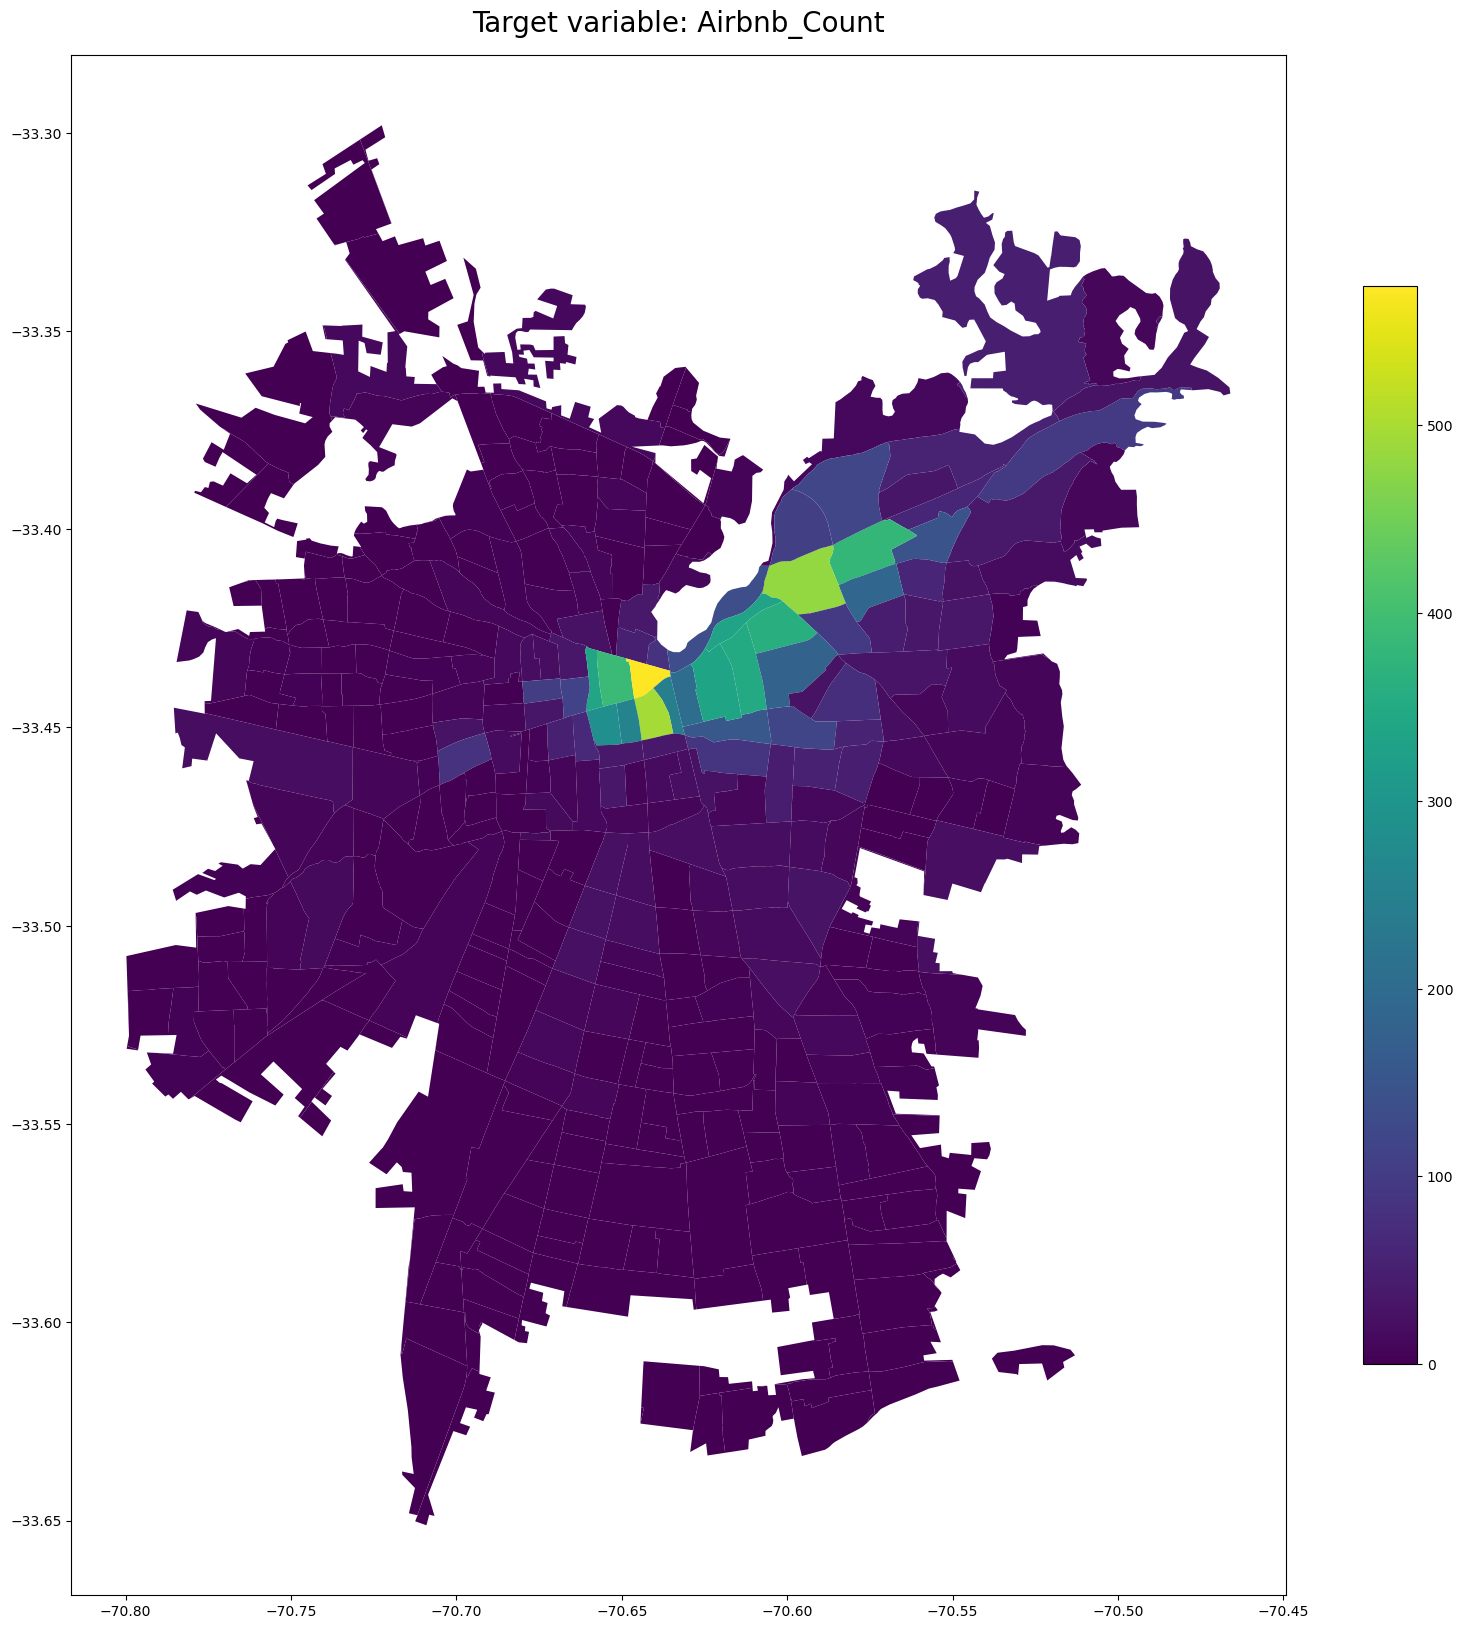

In [13]:
fig, ax = plt.subplots(figsize=(20, 20))

geo_info.plot(
    ax=ax,
    column=VARIABLE_TO_PREDICT,
    legend=True,
    figsize=(20, 20),
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Target variable: " + str(VARIABLE_TO_PREDICT), fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_GWR / "target_variable.svg", format="svg")

plt.show()

# Nans (previusly filled with 0's)

In [14]:
# define the colormap
cmap = plt.cm.Accent_r
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
# cmaplist[0] = (0.5, 0.5, 0.5, 1.0)
cmaplist[0] = "0.8"
# define the bins and normalize
bounds = np.linspace(0, 8, 9)
my_norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

my_cmap = mpl.colors.LinearSegmentedColormap.from_list("Custom cmap", cmaplist, cmap.N)

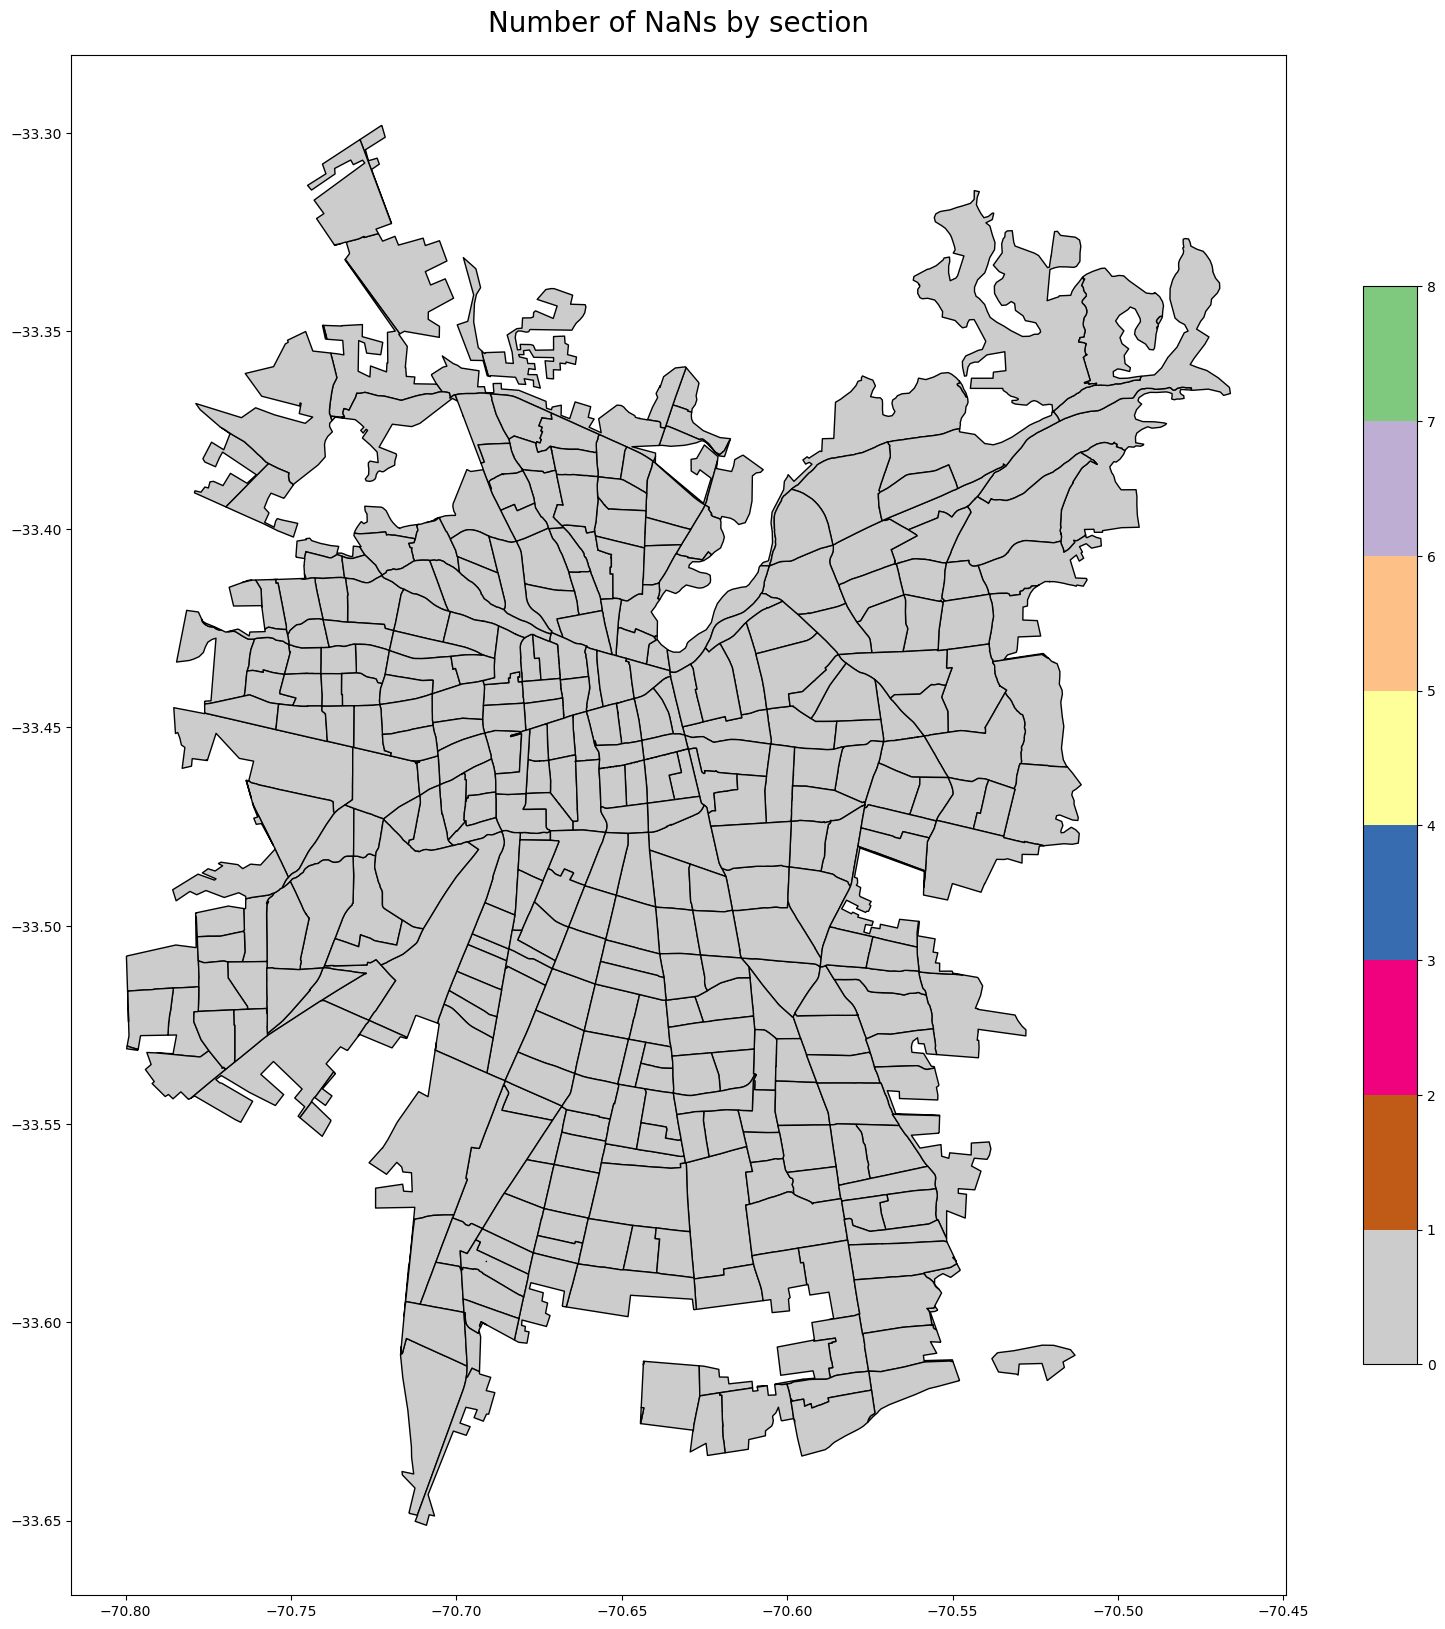

In [15]:
geo_nans["NaNs"] = pd.isnull(sect).sum(axis=1)

fig, ax = plt.subplots(figsize=(20, 20))

geo_nans.plot(
    ax=ax,
    column="NaNs",
    edgecolor="black",
    legend=True,
    norm=my_norm,
    cmap=my_cmap,
    figsize=(20, 20),
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Number of NaNs by section", fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_GWR / "nans.svg", format="svg")

plt.show()

# GWR

### Load best model (frome notebook "12_census_linear.ipynb")

In [16]:
linear_coefs = pd.read_csv(
    PROCESSED_CL / VARIABLE_TO_PREDICT / "01_linear/coefficients.csv", index_col=0
)
best_model = linear_coefs.drop(["Intercept"], axis=1).columns

print(best_model)

Index(['VIVIENDAS_PARTITUCLARES', 'PUEBLO_ORIGINARIO_INDIGENA',
       'Distance_to_Center', 'DENSIDAD_POBLACIONAL', 'VIVIENDAS_COLECTIVAS',
       'shop_pois_count'],
      dtype='object')


In [17]:
X_chosen = sect[best_model]
y_chosen = np.array(sect[VARIABLE_TO_PREDICT]).reshape((-1, 1))

In [18]:
pd.isnull(X_chosen).sum(0)

VIVIENDAS_PARTITUCLARES       0
PUEBLO_ORIGINARIO_INDIGENA    0
Distance_to_Center            0
DENSIDAD_POBLACIONAL          0
VIVIENDAS_COLECTIVAS          0
shop_pois_count               0
dtype: int64

### Preprocessing

Since there are not missing values, we do not have to use a imputer.

We will transform the features so they follow a Gaussain-like distribution.

In [19]:
X_transformed = X_chosen.copy()

if pd.isnull(X_chosen).sum().sum() != 0:
    knn_X = KNNImputer()
    knn_X.fit(X_transformed)
    X_transformed = knn_X.transform(X_transformed)

pw_X = PowerTransformer()
pw_X.fit(X_transformed)
X_transformed = pw_X.transform(X_transformed)

pw_y = PowerTransformer()
pw_y.fit(y_chosen)
y_transformed = pw_y.transform(y_chosen)

### Check multicolinearity

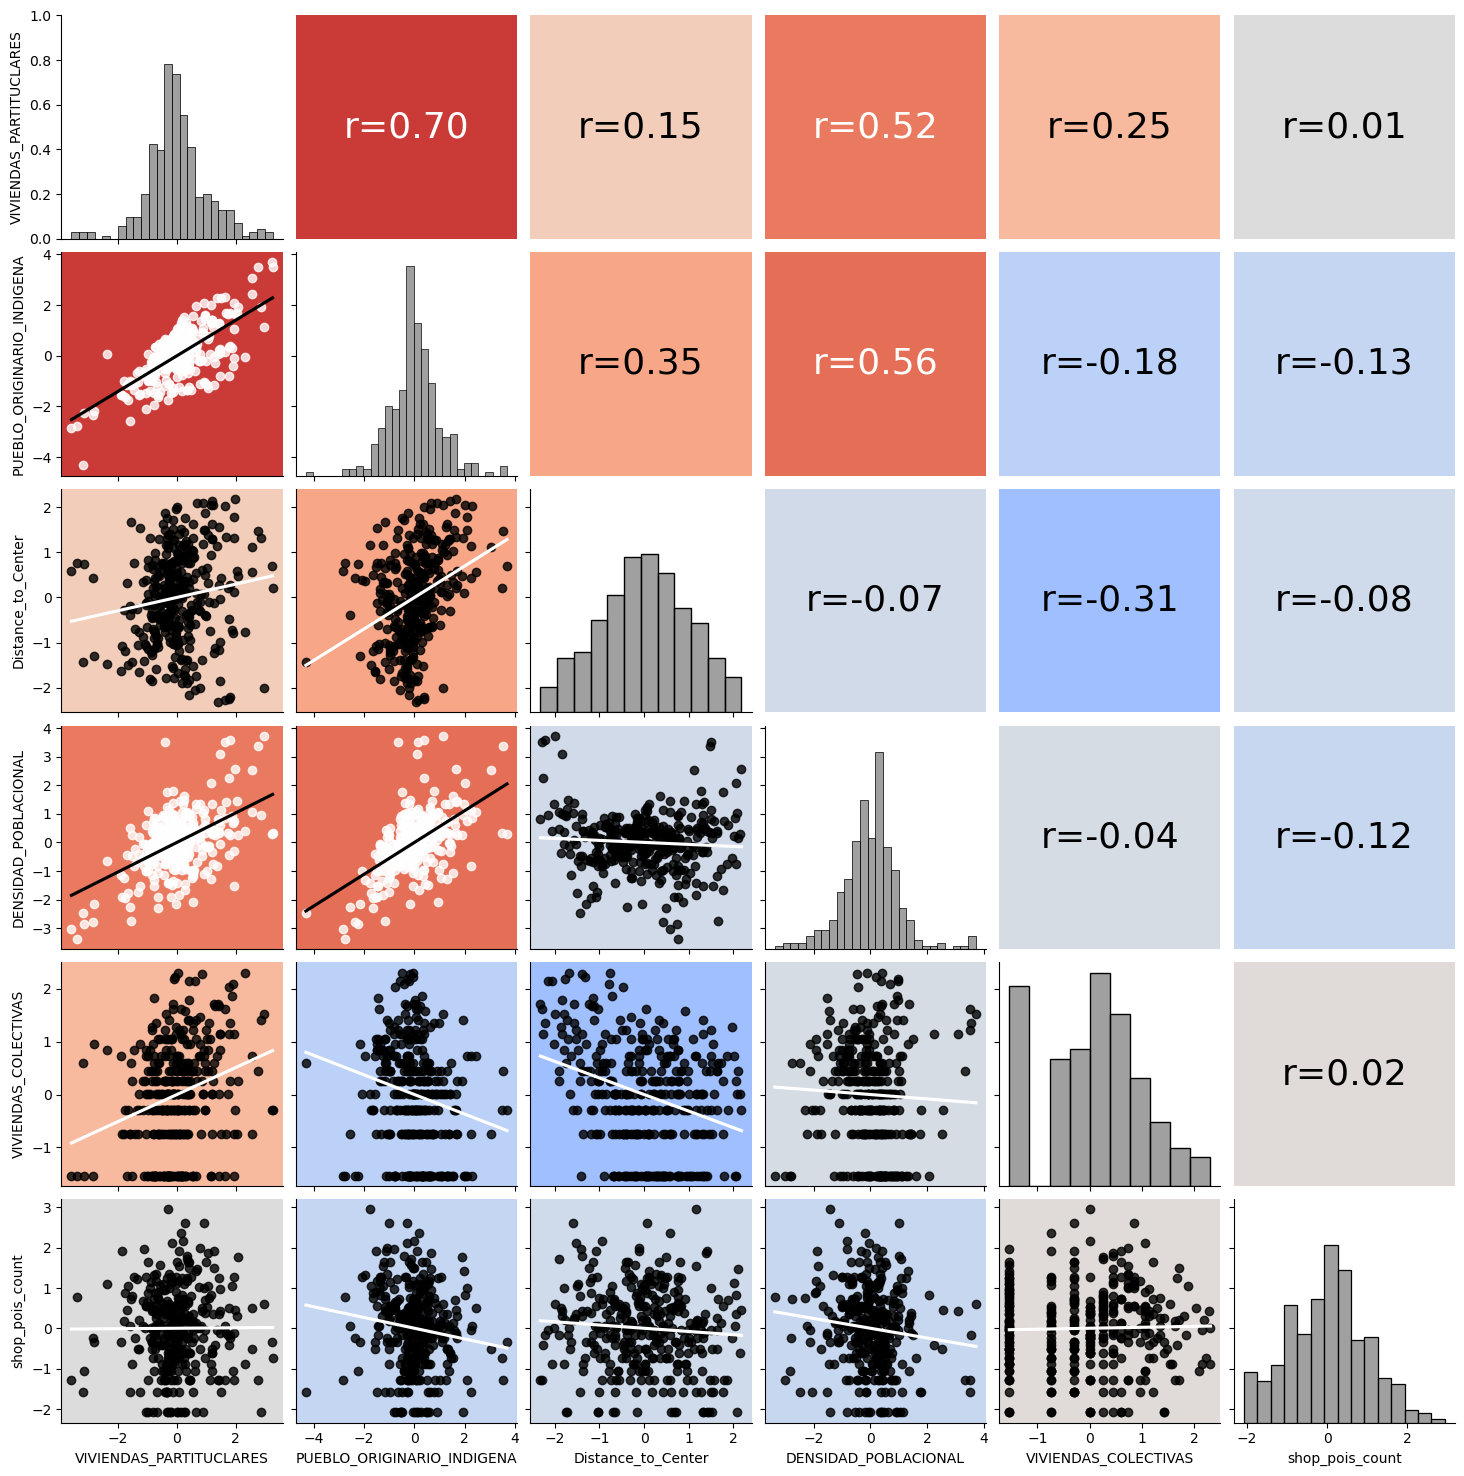

In [20]:
def corrfunc(x, y, **kwds):
    cmap = kwds["cmap"]
    norm = kwds["norm"]
    ax = plt.gca()
    ax.tick_params(bottom=False, top=False, left=False, right=False)
    sns.despine(ax=ax, bottom=True, top=True, left=True, right=True)
    r, _ = pearsonr(x, y)
    facecolor = cmap(norm(r))
    ax.set_facecolor(facecolor)
    lightness = (max(facecolor[:3]) + min(facecolor[:3])) / 2
    ax.annotate(
        f"r={r:.2f}",
        xy=(0.5, 0.5),
        xycoords=ax.transAxes,
        color="white" if lightness < 0.7 else "black",
        size=26,
        ha="center",
        va="center",
    )


def scattfunc(x, y, **kwds):
    cmap = kwds["cmap"]
    norm = kwds["norm"]
    ax = plt.gca()
    r, _ = pearsonr(x, y)
    facecolor = cmap(norm(r))
    lightness = (max(facecolor[:3]) + min(facecolor[:3])) / 2
    myColor = "white" if lightness < 0.7 else "black"
    lineColor = "black" if lightness < 0.7 else "white"
    ax.set_facecolor(facecolor)
    sns.regplot(x=x, y=y, ax=ax, color=myColor, line_kws={"color": lineColor}, ci=None)


g = sns.PairGrid(pd.DataFrame(X_transformed, columns=X_chosen.columns))
g.map_lower(
    scattfunc, cmap=plt.get_cmap("coolwarm"), norm=plt.Normalize(vmin=-0.8, vmax=0.8)
)
g.map_diag(sns.histplot, color="gray", kde=False)
g.map_upper(
    corrfunc, cmap=plt.get_cmap("coolwarm"), norm=plt.Normalize(vmin=-0.8, vmax=0.8)
)
g.fig.subplots_adjust(wspace=0.06, hspace=0.06)  # equal spacing in both directions


if SAVE_FIGS:
    plt.savefig(DIR_GWR / "correlations.svg", format="svg")

In [21]:
vif = pd.DataFrame()
vif["VIF"] = [
    variance_inflation_factor(X_transformed, i) for i in range(X_transformed.shape[1])
]
vif["variable"] = X_chosen.columns

vif

VIF                    variable
0  3.058267     VIVIENDAS_PARTITUCLARES
1  3.227848  PUEBLO_ORIGINARIO_INDIGENA
2  1.395184          Distance_to_Center
3  1.737993        DENSIDAD_POBLACIONAL
4  1.613710        VIVIENDAS_COLECTIVAS
5  1.062962             shop_pois_count

## Model training

### Bandwith selection

In [22]:
gwr_chosen_selector = mgwr.sel_bw.Sel_BW(
    coords, y_transformed, X_transformed, fixed=False, spherical=True, multi=False
)
gwr_bw = gwr_chosen_selector.search()
print("GWR with chosen and transformed features")
print("Bandwith (KNN): " + str(int(gwr_bw)))

GWR with chosen and transformed features
Bandwith (KNN): 114


### Fit the model

In [23]:
# IMPORTANT
# as of the version 2.1.0, pysal uses np.float wich is deprecated at iwls.py:111, wich I changed for this code to work
gwr_model = mgwr.gwr.GWR(
    coords, y_transformed, X_transformed, gwr_bw, constant=FIT_INTERCEPT
)
gwr_results = gwr_model.fit()
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 342
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             93.135
Log-likelihood:                                                    -262.848
AIC:                                                                539.696
AICc:                                                               542.128
BIC:                                                              -1861.526
R2:                                                                   0.728
Adj. R2:                                                              0.723

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

## Model predictions

In [24]:
gwr_model.predict(coords, X_transformed)
y_predicted = gwr_results.predictions
y_predicted

array([[ 1.32984987],
       [ 1.20124623],
       [ 1.30822601],
       [ 1.07257199],
       [ 1.74100894],
       [ 1.8713492 ],
       [ 0.65259971],
       [ 2.36802259],
       [ 1.16904102],
       [ 0.85935077],
       [ 1.8498695 ],
       [ 0.32025809],
       [ 1.22953814],
       [ 1.40243996],
       [ 1.58606535],
       [ 1.53945193],
       [ 0.65116382],
       [ 0.65636221],
       [ 1.87359476],
       [-1.45464757],
       [-1.00009925],
       [-1.01803328],
       [ 0.36094836],
       [ 0.80162204],
       [ 1.79073806],
       [ 1.80300443],
       [ 1.11103857],
       [ 1.52007623],
       [-1.25998143],
       [ 0.7754912 ],
       [-1.42280474],
       [ 0.60614569],
       [-0.01609496],
       [-0.30865618],
       [-0.76746738],
       [-0.64908181],
       [-0.45887929],
       [-0.8458146 ],
       [-0.70524253],
       [-1.36435674],
       [ 0.13285136],
       [ 0.00711471],
       [-0.11996271],
       [-0.4833222 ],
       [-1.17931662],
       [-0

### Transformed (Gaussian) data

In [25]:
y_predicted_transformed = y_predicted.copy()
y_predicted = pw_y.inverse_transform(y_predicted).round().flatten()
y_predicted = pd.Series(y_predicted, name="GWR")
y_truth = pd.Series(y.flatten(), name="True Data")
pa_gwr = PredictedAccuracy(y_truth, y_predicted)

In [26]:
# y_predicted.values
df_predictions = pd.DataFrame(
    y_predicted.values, index=geo_info.index, columns=["Predictions"]
)
df_predictions

Predictions
0           42.0
1           29.0
2           40.0
3           20.0
4          222.0
..           ...
337          0.0
338         -0.0
339         -0.0
340          2.0
341         19.0

[342 rows x 1 columns]

7   NaN
Name: GWR, dtype: float64


ValueError: Input contains NaN.

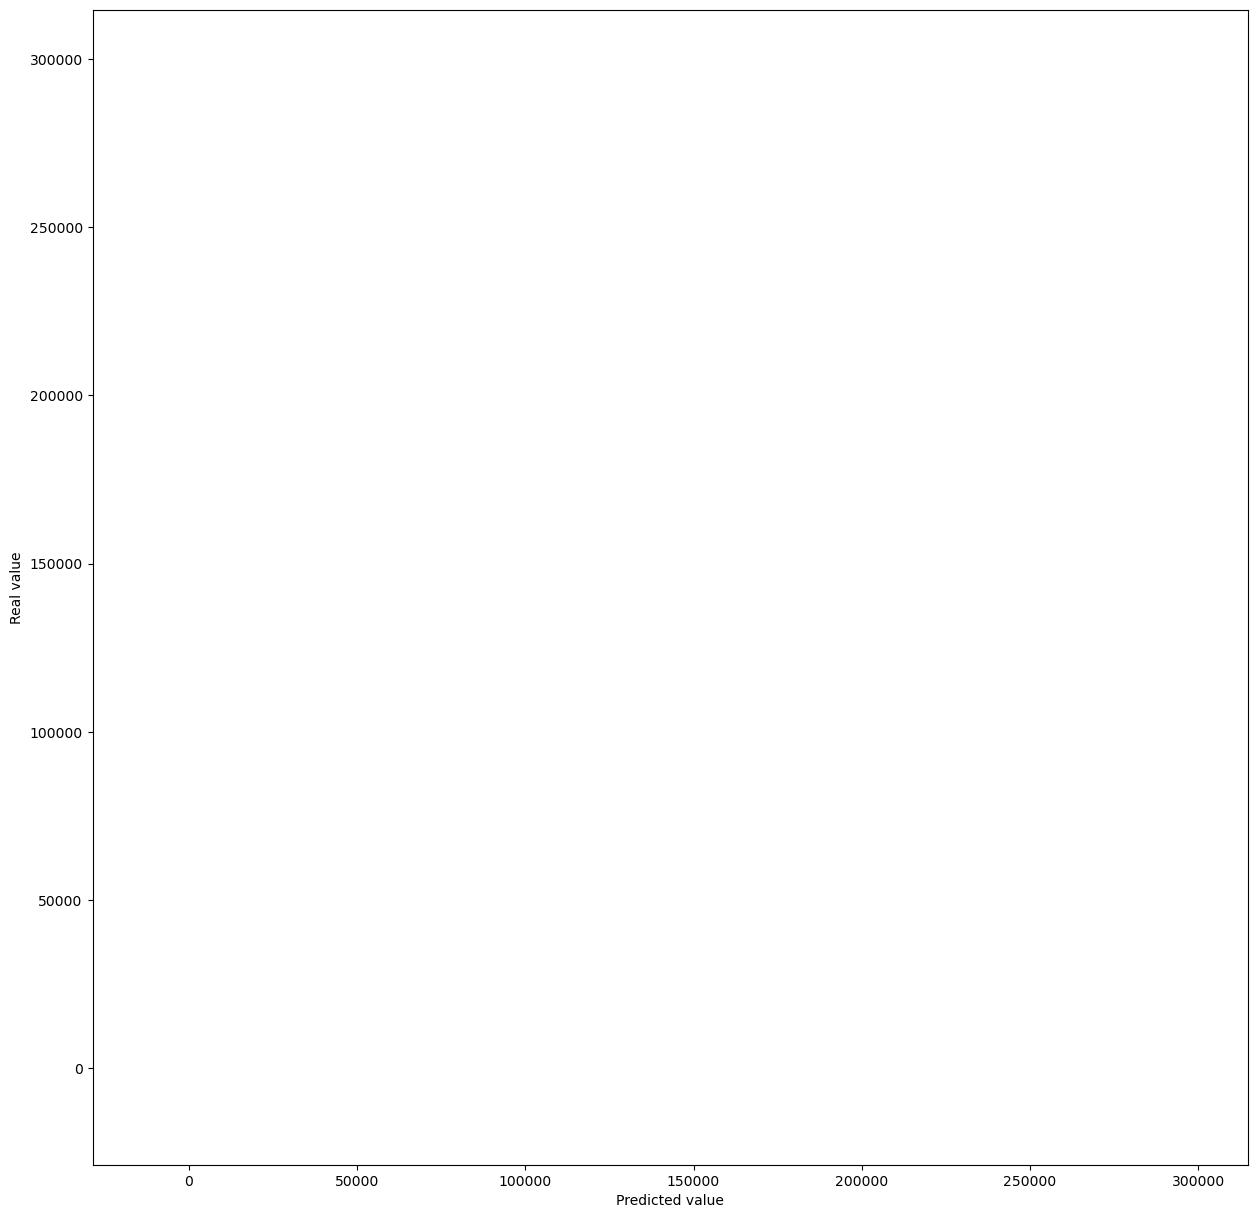

In [27]:
pa_gwr.plot_scatter(save_fig=SAVE_FIGS, root_name=DIR_GWR / "gwr_model")